In [ ]:
# DRIVE CONNECTION
from google.colab import drive
import os #phyton “operating system” kütüphanesi

print("Connecting to Google Drive...")
drive.mount('/content/drive')
print("✅Connection Successful!")

#DOSYA KONTROLÜ
zip_yolu = "/content/drive/MyDrive/Sound Source.zip" #dosyanın gerçekten orda olup olmadığını kontrol ediyo
if os.path.exists(zip_yolu):
    print(f"✅Zip file found: {zip_yolu}")
else:
    print("ERROR: File not found!")


#Hocam, Google Colab geçici (ephemeral) bir ortamdır.
#Tarayıcıyı kapattığımızda içindeki her şey silinir.
#Veri setimiz (Sound Source.zip) büyük olduğu için her seferinde tekrar yüklemek zaman kaybı olurdu.
#Bu yüzden veriyi kalıcı olan Google Drive'da tuttuk ve her çalışmada oradan mount ederek çektik.
#Bu sayede veri güvenliğini ve sürekliliği sağladık.
#Ve ayrıcı dosyanın gerçekte o klosörde var olup olmadığını kontrol ettik.

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅Connection Successful!
✅Zip file found: /content/drive/MyDrive/Sound Source.zip


In [ ]:
# LIBRARIES AND BASIC SETTINGS
import os
import zipfile
import numpy as np
import librosa #ÇOK ÖNEMLİ Ses işleme kütüphanesi
#Sesi yükleyip, saniyelerini ayarlayıp ve Mel-Spektrogram resmine çevirir
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt #Grafik çizmek için
import seaborn as sns #Grafik çizmek için)

# "RIGOR" için rastgeleliği sabitliyoruz(with seed)
torch.manual_seed(42)
np.random.seed(42)

# Sabit Değerler (Config)
ZIP_YOLU = "/content/drive/MyDrive/Sound Source.zip"
CIKARTMA_KLASORU = "./veri_seti"
HEDEF_SURE = 3.0 # Her ses 3 saniye olacak
SR = 22050 #sample rate
HEDEF_UZUNLUK = int(HEDEF_SURE * SR) #input size
BATCH_SIZE = 16 #mini batch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Setup complete. Operating device:{DEVICE}")

Setup complete. Operating device:cuda


In [ ]:
# DATA PRE-PROCESSING AND LOADING

# 1. Zip Dosyasını Açma
if not os.path.exists(CIKARTMA_KLASORU):
    print("📦 Zip file is opening... Please wait")
    with zipfile.ZipFile(ZIP_YOLU, 'r') as zip_ref: #r=sayesinde dosya okuma modunda açılır ve alınabilcek hata karşısında direkt dosyayı kapatır
        zip_ref.extractall(CIKARTMA_KLASORU) #extracall metodu Zip'in içindeki binlerce ses dosyasını alır ve bizim belirlediğimiz CIKARTMA_KLASORU içine tek tek yerleştirir. Asıl ağır işi yapan satır budur.
    print("✅ The zip file has been extracted.")
else:
    print("The files have already been moved to the folder.")

#Bilgisayar ses dosyasını (wav) doğrudan anlayamaz.
#Bu fonksiyon, sesi önce sayılara, sonra da görüntüye (Mel-Spektrogram) çevirir.
#CNN aslında sesi değil, bu oluşturduğumuz resmi analiz eder.
     # 2. Ses İşleme Fonksiyonu (Mel-Spectrogram)
def ses_isleme(dosya_yolu):
    y, sr = librosa.load(dosya_yolu, sr=SR)

    # Süreyi 3 saniyeye sabitle (Eksikse doldur, fazlaysa kırp)
    if len(y) > HEDEF_UZUNLUK:
        y = y[:HEDEF_UZUNLUK]
    else:
        eksik_kisim = HEDEF_UZUNLUK - len(y)
        y = np.pad(y, (0, eksik_kisim), mode='constant')

    #Mel-Spektrogram sesin hem Zaman hem de Frekans bilgisini birleştirir.
    #Ayrıca insan kulağının algısına (Mel Scale) göre ayarlandığı için duygu değişimlerini (tonlama, vurgu) yakalamakta en başarılı yöntem budur.
    #(Not: Bu bilgi literatür taraması kısmında okuduğumuz makalelere dayanıyor.)
    # Sesi resme çevir
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
    return librosa.power_to_db(melspec, ref=np.max)

# 3. Klasörleri Gezip Veriyi Okuma
print("🏭 Data processing...")
X_veri = []
y_etiket = []
duygular = {"Angry": 0, "Calm": 1, "Happy": 2, "Sad": 3}
sinif_isimleri = ["Angry", "Calm", "Happy", "Sad"]

for root, dirs, files in os.walk(CIKARTMA_KLASORU):
    for file in files:
        if file.endswith(".wav") and not file.startswith("._"): # Gizli dosyaları atla file cleaning
            dosya_yolu = os.path.join(root, file)
            klasor_adi = os.path.basename(os.path.dirname(dosya_yolu))

            if klasor_adi in duygular:
                try:
                    veri = ses_isleme(dosya_yolu)
                    X_veri.append(veri)
                    y_etiket.append(duygular[klasor_adi])
                except Exception as e:
                    print(f"Hata: {file} okunamadı.")

# Listeyi Numpy formatına çevir
X = np.array(X_veri)[:, np.newaxis, :, :] # Boyut: (N, 1, 64, 130) renki resim olsa rgb(3boyutlu) olucaktı ama bizim sesimiz siyah beyaz olduğu için 1katmanlı
y = np.array(y_etiket)

#Soru: "Kodundaki [:, np.newaxis, :, :] kısmı ne işe yarıyor? Neden buna ihtiyaç duydun?"
#PyTorch'taki Conv2d (Konvolüsyon) katmanları giriş verisini standart bir formatta bekler:
#(Batch Size, Channel, Height, Width).
#Bizim Mel-Spektrogramlarımız gri tonlamalı (Grayscale) olduğu için renk kanalı boyutu eksikti.
#np.newaxis ile o eksik olan 'Channel=1' boyutunu veriye ekledim.
#Bunu yapmasaydım model boyut uyuşmazlığı hatası (Shape Mismatch Error) verirdi."

print(f"📊 Number of Total Processed Data: {len(X)}")

The files have already been moved to the folder.
🏭 Data processing...
📊 Number of Total Processed Data: 1735


In [ ]:
#SPLIT THE DATA SET
# Adım 1: %80 Eğitim (Train), %20 Geçici
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #stratify sayesinde her duygu her parçaya eşit dağılır

# Adım 2: Geçici kısmı ikiye böl -> %10 Validation, %10 Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Verileri PyTorch formatına (DataLoader) çevir
train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train)), batch_size=BATCH_SIZE, shuffle=True) #shuffle sayesinde overfittingi engelledik
val_loader = DataLoader(TensorDataset(torch.Tensor(X_val), torch.LongTensor(y_val)), batch_size=BATCH_SIZE) #model daha iyi öğrensin diye mini batchlere böldük
test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test)), batch_size=BATCH_SIZE)

print(f"✅ Data Split Complete: Train={len(X_train)}, Validation={len(X_val)}, Test={len(X_test)}")
#literatürde küçük ve orta ölçekli veri setleri (1.000 - 10.000 arası) için en kabul gören standart 80/10/10 ayrımıdır.

✅ Data Split Complete: Train=1388, Validation=173, Test=174


In [ ]:
#BASELINE CNN

class BasitCNN(nn.Module):   #PyTorch'un nn.Module kütüphanesinden miras alarak kendi sınıfımızı oluşturuyoruz
    def __init__(self):
        super(BasitCNN, self).__init__()
        # 3 Katmanlı Evrişim (Convolution) Ağı
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  #burda giderek karmaşık duygular çözülebilir hale gelir 1-> 16 -> 32 -> 64

        # Özellikleri küçültmek için Max Pooling(yarı yarıya düşürülür gereksiz dosyalar atılır)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        # Flatten boyutu: 64 kanal * 8 yükseklik * 16 genişlik = 8192

           #FC1 (Dense Layer): self.fc1 katmanı, Flattendan gelen 8192 inputu alır ve işleyerek 128 hidden feature haline getirir.
        self.fc1 = nn.Linear(64 * 8 * 16, 128) #nn.Linear PyTorchta fully connected layers demektir (y = Wx + b)
           #FC2 (Output Layer): self.fc2 katmanı, bu 128 feature bilgisini alır ve sonuç olarak 4 class score üretir.
        self.fc2 = nn.Linear(128, 4) # 4 duygu classımız var diye outputu 4 olmak zorunda(her classa ayrı olasılık üretir)
        self.dropout = nn.Dropout(0.3) # train sırasında DROPOUT(sadece train anında çalışır) nöronların %30unu kapatarak overfittingi önler

    def forward(self, x): #Forward Propagation Conv->ReLu->Pool
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) #Sigmoid derin ağlarda Vanishing Gradient problemine yol açıyor, öğrenmeyi durduruyor.
        x = self.pool(F.relu(self.conv3(x))) #ReLU türevi koruduğu için daha derin modelleri eğitebiliyoruz ve computational cost'u çok daha düşük.

        x = x.view(x.size(0), -1) # FC sadece vectör kabul ettiği için Flatten ile 3D to 1D
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Modeli oluştur ve GPU'ya gönder
model = BasitCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss() #loss func y ile y^ arasındaki farkı hesaplar
optimizer = optim.Adam(model.parameters(), lr=0.001) #optimizer olarak adam kullandık çünkü Momentum tabanlı olduğu için SGD'ye göre daha hızlı Convergence sağlıyor ve Local mine takılma riski daha az.

print("🧠 The model has been successfully created.")

🧠 The model has been successfully created.


In [ ]:
#MODEL TRAINING
print("🚀 The training is starting...")

train_losses = []
val_accuracies = []
best_acc = 0.0
EPOCH_SAYISI = 20

for epoch in range(EPOCH_SAYISI):
    # TRAIN Mode
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #data GPUya taşı Veriyi neden .to(DEVICE) ile taşıyoruz?=PyTorch kütüphanesi matematiksel işlem yapabilmek için Model'in ve data'nin aynı fiziksel bellekte olmasını zorunlu kılar.

        optimizer.zero_grad() #gradienti(geçmiş hataları) sıfırla
        loss = criterion(model(inputs), labels) #loss hesabı
        loss.backward() #Hangi nöronun hatada ne kadar payı olduğunu bulur (Gradient Calculation)
        optimizer.step()
        running_loss += loss.item()

    # VALIDATION Mode
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            #skor hesabı şimdi başlar
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Ortalamaları hesapla
    avg_loss = running_loss / len(train_loader)
    acc = 100 * correct / total

    train_losses.append(avg_loss)
    val_accuracies.append(acc)

    # En iyi modeli kaydet
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model1.pth')
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f} | Accuracy=%{acc:.2f} (⭐ Yeni Rekor!)")
    else:
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f} | Accuracy=%{acc:.2f}")

print(f"🏁 Training is complete! Highest achievement: %{best_acc:.2f}")

🚀 The training is starting...
Epoch 1: Loss=0.4235 | Accuracy=%71.68 (⭐ Yeni Rekor!)
Epoch 2: Loss=0.4179 | Accuracy=%74.57 (⭐ Yeni Rekor!)
Epoch 3: Loss=0.3837 | Accuracy=%72.83
Epoch 4: Loss=0.3503 | Accuracy=%78.03 (⭐ Yeni Rekor!)
Epoch 5: Loss=0.3779 | Accuracy=%76.30
Epoch 6: Loss=0.3480 | Accuracy=%75.14
Epoch 7: Loss=0.3407 | Accuracy=%79.19 (⭐ Yeni Rekor!)
Epoch 8: Loss=0.3255 | Accuracy=%74.57
Epoch 9: Loss=0.3153 | Accuracy=%75.72
Epoch 10: Loss=0.2817 | Accuracy=%78.61
Epoch 11: Loss=0.2690 | Accuracy=%73.99
Epoch 12: Loss=0.2539 | Accuracy=%76.88
Epoch 13: Loss=0.2419 | Accuracy=%77.46
Epoch 14: Loss=0.2081 | Accuracy=%79.77 (⭐ Yeni Rekor!)
Epoch 15: Loss=0.2393 | Accuracy=%75.72
Epoch 16: Loss=0.1674 | Accuracy=%78.03
Epoch 17: Loss=0.1793 | Accuracy=%77.46
Epoch 18: Loss=0.1650 | Accuracy=%80.35 (⭐ Yeni Rekor!)
Epoch 19: Loss=0.1825 | Accuracy=%76.30
Epoch 20: Loss=0.1945 | Accuracy=%78.61
🏁 Training is complete! Highest achievement: %80.35


🕵️‍♂️ Final Test...

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       Angry       0.81      0.90      0.85        49
        Calm       0.67      0.71      0.69        41
       Happy       0.89      0.71      0.79        35
         Sad       0.76      0.76      0.76        49

    accuracy                           0.78       174
   macro avg       0.78      0.77      0.77       174
weighted avg       0.78      0.78      0.78       174



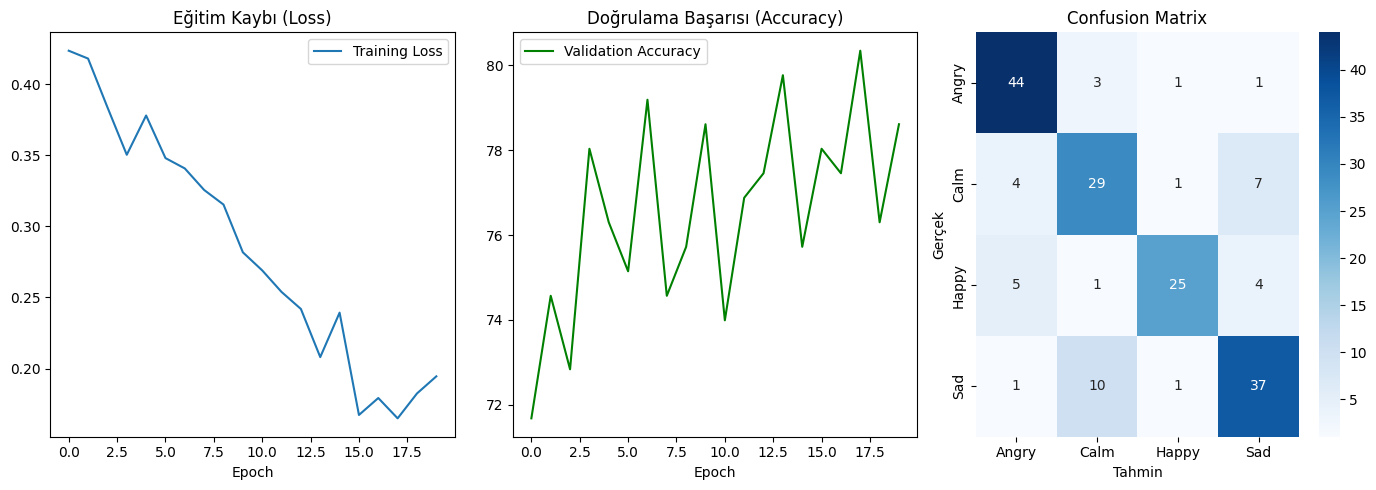

In [ ]:
# FINAL TEST SCORES AND ANALYS

print("🕵️‍♂️ Final Test...")

# En iyi modeli geri yükle
model.load_state_dict(torch.load('best_model1.pth'))
model.eval()

y_gercek = []
y_tahmin = []

with torch.no_grad():
    for inputs, labels in test_loader: # Test Loader kullanıyoruz!
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #Veriyi GPU'ya atar ve modelden tahmin ister
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_gercek.extend(labels.cpu().numpy())
        y_tahmin.extend(predicted.cpu().numpy())

# 1. Detaylı Rapor (F1-Score, Precision)
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_gercek, y_tahmin, target_names=sinif_isimleri))

# 2. Grafikler
plt.figure(figsize=(14, 5))

# Sol: Kayıp Grafiği
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Eğitim Kaybı (Loss)')
plt.xlabel('Epoch')
plt.legend()

# Orta: Başarı Grafiği
plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Doğrulama Başarısı (Accuracy)')
plt.xlabel('Epoch')
plt.legend()

# Sağ: Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_gercek, y_tahmin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sinif_isimleri, yticklabels=sinif_isimleri)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')

plt.tight_layout()
plt.show()